### Проект по предсказанию цены на недвижимость

__Задание:__

Используя данные из `train.csv`, построить модель для предсказания цен на недвижимость (квартиры).   
С помощью полученной модели предсказать цены для квартир из файла `test.csv`.

__Целевая переменная:__

`Price`

__Метрика:__

R2 - коэффициент детерминации (`sklearn.metrics.r2_score`)

__Сроки и условия сдачи:__

* Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.

__Примечание:__ 

Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию, но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения, которые были в курсе Python для Data Science. Градиентный бустинг изучается в последующих курсах, поэтому в этом проекте его применять не следует. Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

**Для чего нужно?**

*В банках, страховых компаниях:*

* Узнать истинную стоимость имущества (залога)
* Принять решение о выдаче ипотеки/страховки
* Принять решение о % по ипотеке/страховке

*На площадках объявлений (Авито, Циан, ...):*

* Найти недооцененные квартиры (~ выгодные предложения), показать их пользователям
* Показывать рыночную стоимость квартиры пользователям
* Для тех, кто продает квартиру, рекомендовать цену продажи

*Для инвесторов в недвижимость:*

* Определять рыночную стоимость квартир
* Поиск недооцененных активов
* Торговля на рынке недвижимости

### Подключение библиотек и загрузка данных

In [152]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# rcParams['figure.figsize'] = 10, 8
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 100

In [153]:
TRAIN_DATASET_PATH='train.csv'
TEST_DATASET_PATH='test.csv'
PREPARED_TRAIN_DATASET_PATH='train_prepared.csv'
PREPARED_TEST_DATASET_PATH='test_prepared.csv'

In [154]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):

    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(10,6))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [155]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

## Описание датасета

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [156]:
df_train.describe()

Id    DistrictId         Rooms        Square   LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  7887.000000   
mean    8383.40770     50.400800      1.890500     56.315775    37.199645   
std     4859.01902     43.587592      0.839512     21.058732    86.241209   
min        0.00000      0.000000      0.000000      1.136859     0.370619   
25%     4169.50000     20.000000      1.000000     41.774881    22.769832   
50%     8394.50000     36.000000      2.000000     52.513310    32.781260   
75%    12592.50000     75.000000      2.000000     65.900625    45.128803   
max    16798.00000    209.000000     19.000000    641.065193  7480.592129   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
std        28.560917      5.241148      6.775974  2.005003e+05      0.119025   
min         0.000000      1.000000      0.000000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1   Helthcare_2  \
count  10000.000000  10000.000000  10000.000000   5202.000000  10000.000000   
mean      24.687000   5352.157400      8.039200   1142.904460      1.319500   
std       17.532614   4006.799803     23.831875   1021.517264      1.493601   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7227.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  10000.000000   10000.000000  
mean       4.231300  214138.857399  
std        4.806341   92872.293865  
min        0.000000   59174.778028  
25%        1.000000  153872.633942  
50%        3.000000  192269.644879  
75%        6.000000  249135.462171  
max       23.000000  633233.466570

* Id - id наблюдения, сделаем строкой
* DistrictID - номер района, показывает количество наблюдений по этому району (колво квартир), соответственно, популярность района. Скорее всего в районах, где больше всего наблюдений - будет больше население, соответственно, цена на квартиры там ниже
* Rooms - видно, что самые популярные - 1, 2 комнатные квартиры. 0 комнат - возможно, студия, нужно смотреть на все остальное. 19 комнат - очевидно, нетиповая квартира
* Square - здесь есть странные маленькие значения, плюс надо смотреть, чтобы суммарно площадь была не меньше, чем сумма площади кухни и жилой. Большая площадь тоже редкое явление. 
* LifeSquare - есть слишком маленькие площади и есть большие - выбросы, много нулей - их заполним алгоритмом 
* KitchenSquare - есть явные выбросы в виде больших площадей, 0 - вопрос (может быть, студия?)
* Floor - не должен быть выше, чем этажность дома
* HouseFloor - нулевая этажность - выбросы
* HouseYear - есть слишком старые дома - ?
* Shops - в спальных районах всегда больше магазинов, там скорее всего будет больше численность населения и больше квартир
* Healthcare - приметно так же как и с магазинами, чем больше людей, тем должны быть выше показатели здравоохранения (мможет быть, кол-во поликлиник, или какое-нибудь соотношение численности к кол-ву людей) - ?
* Ecology - скорее всего коэффициент, пока не знаю, как его связать с данными
* Social - наверное, плотность населения или какие-то еще показатели, можно посмотреть связь с DistrictId

### Обзор целевой переменной

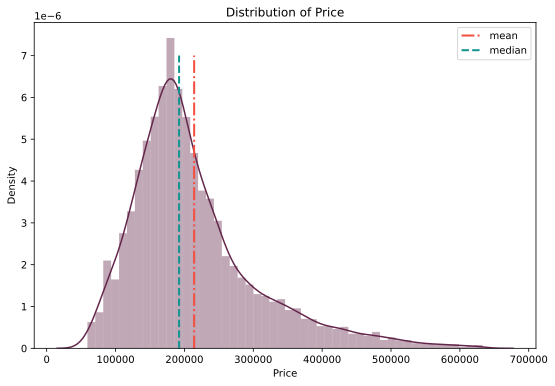

Mean price:  214138.86 
Median price:  192269.64487934904


In [157]:
price = df_train['Price']
price_mean = round(price.mean(), 2)
price_median = price.median()
price_mode = price.mode()[0]

plt.figure(figsize = (9, 6))

sns.distplot(price, color='#63264a')

y = np.linspace(0, 0.000007, 150)
plt.plot([price_mean] * 150, y, label='mean', linestyle='-.', linewidth=2, color='#F44E3F')
plt.plot([price_median] * 150, y, label='median', linestyle='--', linewidth=2, color='#129490')

plt.title('Distribution of Price')
plt.legend()
plt.show()

print('Mean price: ', price_mean, '\nMedian price: ', price_median)

Видно, что на графике распределение цен близко к нормальному, выбросов нет. Самый популярный диапазон цен - от 80000 до 280000 - скорее всего это цены на 1-2 комнатные квартиры, дешевле, возможно, студии, а дорогие встречаются реже. 

### Анализ признаков

* Square, LifeSquare, KitchenSquare

Построим графики распределения площадей. Выделим отдельный датафрейм, в котором отсортируем данные по столбцу Square. 

In [158]:
squares = df_train[['Square', 'LifeSquare', 'KitchenSquare']].sort_values('Square')
squares

Square  LifeSquare  KitchenSquare
6392    1.136859    4.525736            1.0
8283    1.988943    2.642219            1.0
4853    2.377248    0.873147            0.0
1608    2.596351    4.604943            1.0
9294    2.954309    5.257278            1.0
...          ...         ...            ...
1981  212.932361  211.231125            0.0
1982  275.645284  233.949309           26.0
4690  409.425181  410.639749           10.0
4262  604.705972         NaN            1.0
6977  641.065193  638.163193           10.0

[10000 rows x 3 columns]

По таблице видно, что значения площадей меняются от ~1 до 641, при этом, в целом, суммарные значения жилой площади и площади кухни примерно совпадают со значениями площади. Если есть у Life Square значения, выходящие за пределы площади и неадекватные площади кухни - При обработке попробуем их заменить на что-то более адекватное

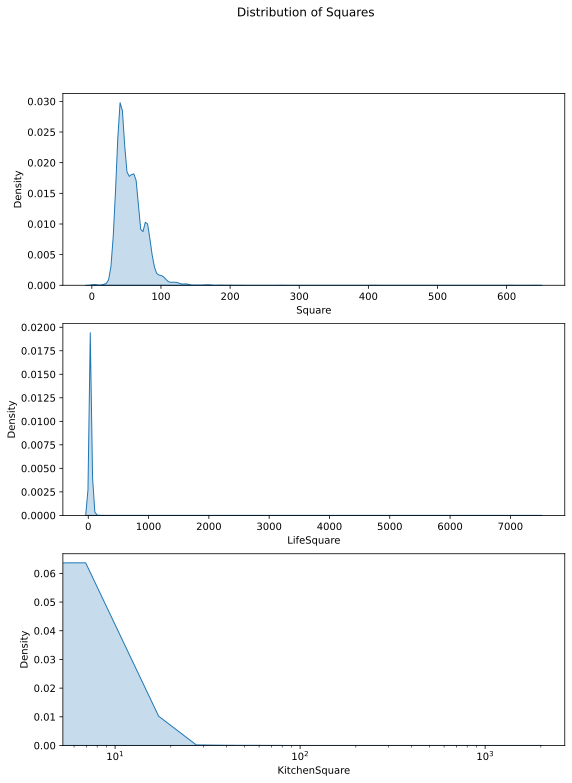

In [159]:
plt.figure(figsize = (9, 12))

plt.subplot(311)
sns.kdeplot(squares['Square'], shade=True, legend=False)
plt.xlabel('Square')

plt.subplot(312)
sns.kdeplot(squares['LifeSquare'], shade=True, legend=False)
plt.xlabel('LifeSquare')

plt.subplot(313)
sns.kdeplot(squares['KitchenSquare'], shade=True, legend=False)
plt.xscale('log')
plt.xlabel('KitchenSquare')

plt.suptitle('Distribution of Squares')
plt.show()

Видно, что у каждой из площадей есть слишком низкие и высокие значения:   
У Square - меньше 20 и больше 200  
У LifeSquare - больше 200  
У KitchenSquare - примерно больше 60 (?)  

Посмотрим на значения в разрезе целевой переменной

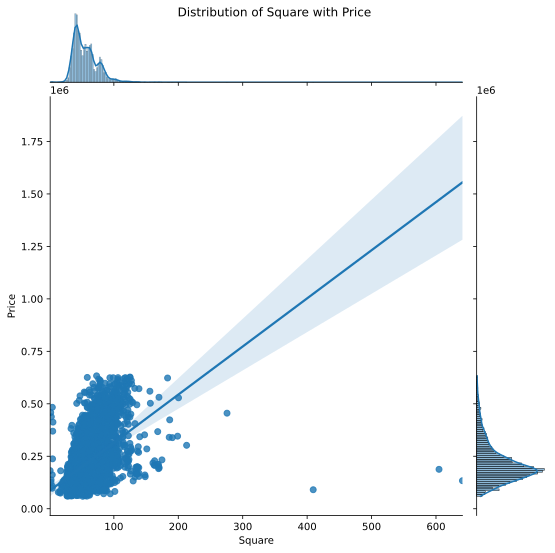

In [160]:
grid = sns.jointplot(df_train['Square'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.suptitle('Distribution of Square with Price')
plt.show()

In [161]:
df_train.loc[(df_train['Square'] > 200) | (df_train['Square'] < 15)].sort_values('Square')

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
6392  14786           1    1.0    1.136859    4.525736            1.0      3   
8283  15744          34    1.0    1.988943    2.642219            1.0     21   
4853   3224          27    0.0    2.377248    0.873147            0.0      1   
1608  10202           6    1.0    2.596351    4.604943            1.0      3   
9294   6782          45    1.0    2.954309    5.257278            1.0      3   
3280  10527          27    1.0    4.380726   40.805837            1.0     10   
4900   4504          27    3.0    4.390331    5.610772            1.0      8   
9613   7657          38    1.0    4.502784    4.618547            1.0     28   
1316  11526          27    1.0    4.633498    1.969969            1.0     18   
8030  13265           1    3.0    4.823679   79.767964            0.0      6   
3413   9487           5    1.0    5.129222    5.549458            1.0      1   
212    1748          88    2.0    5.497061   67.628717            1.0     24   
4739  12676          81    3.0   13.784865   15.988889            7.0      4   
9910  16568          27    4.0  200.334539  201.627361           25.0      1   
1981   7917          27    0.0  212.932361  211.231125            0.0      2   
1982   5548          86    5.0  275.645284  233.949309           26.0     12   
4690   2307         102    1.0  409.425181  410.639749           10.0      4   
4262     28           9    2.0  604.705972         NaN            1.0     17   
6977  11602          30    2.0  641.065193  638.163193           10.0     20   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
6392         1.0       1977   0.007122         B         B         1   
8283         4.0       1977   0.069753         B         B        53   
4853         0.0       1977   0.017647         B         B         2   
1608        25.0       2014   0.243205         B         B         5   
9294         1.0       1977   0.195781         B         B        23   
3280        17.0       2013   0.211401         B         B         9   
4900        19.0       2016   0.211401         B         B         9   
9613         1.0       1977   0.060753         B         B        15   
1316         1.0       1977   0.011654         B         B         4   
8030        17.0       1977   0.007122         B         B         1   
3413         1.0       1977   0.150818         B         B        16   
212         22.0       1977   0.127376         B         B        43   
4739         5.0       1960   0.319809         B         B        25   
9910         2.0       2013   0.041116         B         B        53   
1981         3.0       2008   0.211401         B         B         9   
1982        37.0       2011   0.161976         B         A        31   
4690         4.0       2016   0.238617         B         B        26   
4262        18.0       1977   0.161532         B         B        25   
6977        19.0       2019   0.000078         B         B        22   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
6392       264         0           NaN            0        1       B   
8283     13670         4           NaN            1       11       B   
4853       469         0           NaN            0        0       B   
1608      1564         0         540.0            0        0       B   
9294      5212         6           NaN            3        2       B   
3280      1892         0           NaN            0        1       B   
4900      1892         0           NaN            0        1       B   
9613      2787         2         520.0            0        7       B   
1316       915         0           NaN            0        0       B   
8030       264         0           NaN            0        1       B   
3413      3433         4        2643.0            4        5       B   
212       8429         3           NaN            3        9       B   
4739      4756        16       

Выбросами будем считать площадь больше 400 и меньше 10

In [162]:
grid = sns.jointplot(df_train['LifeSquare'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.suptitle('Distribution of LifeSquare with Price')
plt.show()

In [163]:
df_train.loc[df_train['LifeSquare'] > 250].sort_values('LifeSquare')
# df_test.loc[df_test['LifeSquare'] > 250].sort_values('LifeSquare')

Id  DistrictId  Rooms      Square   LifeSquare  KitchenSquare  Floor  \
590   14990          23    2.0   48.449873   263.542020            5.0      6   
4690   2307         102    1.0  409.425181   410.639749           10.0      4   
8437  15886          85    3.0   78.059331   461.463614           10.0     12   
6977  11602          30    2.0  641.065193   638.163193           10.0     20   
4328  16550          27    3.0   81.694417  7480.592129            1.0      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
590          5.0       1972   0.075779         B         B         6   
4690         4.0       2016   0.238617         B         B        26   
8437        16.0       1998   0.037178         B         B        52   
6977        19.0       2019   0.000078         B         B        22   
4328        17.0       2016   0.017647         B         B         2   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
590       1437         3           NaN            0        2       B   
4690      3889         6         705.0            3        6       B   
8437     11217         1        2300.0            1        7       B   
6977      6398       141        1046.0            3       23       B   
4328       469         0           NaN            0        0       B   

              Price  
590   141780.231857  
4690   90470.430830  
8437  394253.299978  
6977  133529.681562  
4328  217357.492366

Выбросами будем считать все значения меньше 10 больше 250, и те , которые больше общей площади заменим их на разницу между Square KitchenSquare

In [164]:
grid = sns.jointplot(df_train['KitchenSquare'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.suptitle('Distribution of KitchenSquare with Price')
plt.show()

In [165]:
df_train.loc[(df_train['KitchenSquare'] > 50) | (df_train['KitchenSquare'] == 0)].sort_values('KitchenSquare')

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
2      4765          53    2.0   44.947953   29.197612            0.0      8   
6589   9731           1    2.0   52.192543         NaN            0.0      7   
6599   9162          52    1.0   43.963230         NaN            0.0     10   
6607    657           6    2.0   68.556375         NaN            0.0     14   
6609  13491           0    1.0   38.178277    0.370619            0.0     19   
...     ...         ...    ...         ...         ...            ...    ...   
4651  12552          58    3.0  116.405693  113.109653          112.0      3   
2969   7441          62    3.0  114.734473  112.589083          112.0      3   
9895   2737          27    3.0  123.430072  125.806981          123.0      5   
8584  14679          81    1.0   32.276663   19.278394         1970.0      6   
1064  14656          62    1.0   47.100719   46.447960         2014.0      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
2           12.0       1968   0.049637         B         B        34   
6589        17.0       1977   0.007122         B         B         1   
6599        17.0       1977   0.371149         B         B        34   
6607        17.0       1977   0.243205         B         B         5   
6609        17.0       2016   0.006076         B         B        30   
...          ...        ...        ...       ...       ...       ...   
4651         3.0       2016   0.437885         B         B        23   
2969         3.0       2015   0.072158         B         B         2   
9895        10.0       2015   0.017647         B         B         2   
8584         1.0       1977   0.006076         B         B        30   
1064         1.0       2014   0.072158         B         B         2   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
2         7759         0         229.0            1        3       B   
6589       264         0           NaN            0        1       B   
6599      7065         1         750.0            2        5       B   
6607      1564         0         540.0            0        0       B   
6609      5285         0         645.0            6        6       B   
...        ...       ...           ...          ...      ...     ...   
4651      5735         3        1084.0            0        5       B   
2969       629         1           NaN            0        0       A   
9895       469         0           NaN            0        0       B   
8584      5285         0         645.0            6        6       B   
1064       629         1           NaN            0        0       A   

              Price  
2     220925.908524  
6589  200573.760515  
6599  134376.081358  
6607  190216.681029  
6609  105134.286994  
...             ...  
4651  296165.936689  
2969  315245.521059  
9895  234194.837047  
8584  105539.556275  
1064  108337.484207  

[718 rows x 20 columns]

In [166]:
df_train.loc[(df_train['KitchenSquare'] > 40)].sort_values('KitchenSquare')

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
4588    448          48    1.0   41.186904    1.626502           41.0      2   
4142  15466          88    1.0   42.357487   44.779714           41.0     10   
3431   7111          27    2.0  139.070296   89.787666           42.0      5   
7480  10546          62    1.0   46.013187   43.417043           43.0      4   
1867   3267          58    3.0  138.980817  138.004600           43.0      2   
551    1315           6    1.0   48.128114   45.023531           48.0     21   
5904    673          27    1.0   54.418214   51.498581           51.0     10   
9889  12918          23    2.0   51.440463   53.134243           51.0      3   
1860   4265         161    2.0   53.216778   32.644859           53.0      7   
8232   7162          34    2.0   56.738764   57.510395           54.0     26   
6036  12666          34    2.0   60.603363    2.400832           58.0     14   
5162  11739          27    2.0   61.070298   59.845092           58.0      8   
4110    299          27    2.0   66.787523   64.616662           60.0     14   
5888  16593          52    2.0   64.859242         NaN           62.0     15   
4079   6508          23    2.0   67.146049   33.959154           63.0      5   
1369   2371          27    2.0   68.841073   64.234956           66.0      4   
227   16395           2    3.0   79.722243   44.731219           72.0     12   
5149  13703          42    1.0   38.071692   19.723548           73.0      9   
6240   4966          96    3.0   78.445675   47.146757           75.0      9   
1455  12507          54    2.0   79.810535   79.578961           78.0     10   
7088   6569          27    1.0   38.220258   18.716856           84.0      4   
2916  12390          72    3.0   97.490674   99.323558           96.0     22   
4651  12552          58    3.0  116.405693  113.109653          112.0      3   
2969   7441          62    3.0  114.734473  112.589083          112.0      3   
9895   2737          27    3.0  123.430072  125.806981          123.0      5   
8584  14679          81    1.0   32.276663   19.278394         1970.0      6   
1064  14656          62    1.0   47.100719   46.447960         2014.0      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
4588         1.0       1977   0.041125         B         B        46   
4142        19.0       2016   0.127376         B         B        43   
3431         3.0       2016   0.014073         B         B         2   
7480        17.0       2019   0.072158         B         B         2   
1867         2.0       1977   0.437885         B         B        23   
551          1.0       2013   0.243205         B         B         5   
5904        17.0       2017   0.072158         B         B         2   
9889        17.0       2017   0.005767         B         B         1   
1860        17.0       1994   0.000699         B         B        14   
8232        25.0       2016   0.069753         B         B        53   
6036        22.0       1977   0.069753         B         B        53   
5162        17.0       2016   0.072158         B         B         2   
4110        20.0       2015   0.017647         B         B         2   
5888        17.0       1977   0.371149         B         B        34   
4079        17.0       2019   0.034656         B         B         0   
1369         2.0       2014   0.017647         B         B         2   
227         16.0       1987   0.130618         B         B        39   
5149        10.0       2006   0.158249         B         B        21   
6240        12.0       1977   0.041116         B         B        53   
1455        15.0       2014   0.006076         B         B        30   
7088        17.0       2018   0.011654         B         B         4   
2916        25.0       2019   0.210473         B         B        11   
4651         3.0       2016   0.437885         B         B        23   
2969         3.0       2015   0.072158  

In [167]:
# * Square, LifeSquare, KitchenSquare



# "Посмотрим на распределение цен по квантилям, видно, что при значении 99,9 кривая резко растет в верх, а начиная с 0,01 начинает расти, следовательно, все, что выходит за рамки этих квантилей - выбросы"
# можно использовать np.clip() для обрезки значений

# S = [np.percentile(df_train['Square'].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
# LS = [np.percentile(df_train['LifeSquare'].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
# KS = [np.percentile(df_train['KitchenSquare'].dropna(), q=x) for x in np.arange(1, 100, 0.1)]

# plt.figure(figsize = (9, 6))
# plt.plot(np.arange(1, 100, 0.1), S, linewidth=1)
# plt.plot(np.arange(1, 100, 0.1), LS, linewidth=1)
# plt.plot(np.arange(1, 100, 0.1), KS, linewidth=1)
# plt.xlabel('Quantile', size=12)
# plt.ylabel('Square', size=12)

In [168]:
# Посмотрим на эти значения в датафрейме
# square = df_train['Square']
# life_sq = df_train['LifeSquare']
# kitchen_sq = df_train['KitchenSquare']

# df_train = df_train[square.isnull() |
#                    (square < square.quantile(.99)) &
#                    (square > square.quantile(.01))]

# df_train = df_train[life_sq.isnull() |
#                    (life_sq < life_sq.quantile(.99)) &
#                    (life_sq > life_sq.quantile(.01))]

# df_train = df_train[kitchen_sq.isnull() |
#                    (kitchen_sq < kitchen_sq.quantile(.99)) &
#                    (kitchen_sq > kitchen_sq.quantile(.01))]

### Предобработка данных

* `Id` - id наблюдения, сделаем строковым типом, чтобы столбец не участвовал в вычислениях

In [169]:
df_train['Id'] = df_train['Id'].astype(str)
df_test['Id'] = df_test['Id'].astype(str)

* `Square` - Выбросы - больше 400 и меньше 10 - Те данные, которые >400 удалим,  <10 пока оставим, так как в тестовых данных встречаются подобные значения.
Добавим дополнительный признак для выбросов

In [170]:
df_train['OutliersSquare'] = 0
df_train['OutliersSquare'].loc[(df_train['Square'] > 400) | (df_train['Square'] < 10)] = 1

df_test['OutliersSquare'] = 0
df_test['OutliersSquare'].loc[(df_test['Square'] > 400) | (df_test['Square'] < 10)] = 1

In [171]:
df_train = df_train.loc[df_train['Square'] < 400]

* `LifeSquare` - Выбросы - больше 250 и меньше 10 - Те данные, которые >1000 разделим на 100, те, которые >250 разделим на 10,  <10 пока оставим, так как в тестовых данных встречаются подобные значения

In [172]:
df_train['OutliersLifeSquare'] = 0
df_train['OutliersLifeSquare'].loc[(df_train['LifeSquare'] > 250) | (df_train['LifeSquare'] < 10)] = 1

df_test['OutliersLifeSquare'] = 0
df_test['OutliersLifeSquare'].loc[(df_test['LifeSquare'] > 250) | (df_test['LifeSquare'] < 10)] = 1

In [173]:
df_train['LifeSquare'].loc[df_train['LifeSquare'] > 1000] = df_train['LifeSquare'] / 100
df_train['LifeSquare'].loc[df_train['LifeSquare'] > 250] = df_train['LifeSquare'] / 10

df_test['LifeSquare'].loc[df_test['LifeSquare'] > 1000] = df_test['LifeSquare'] / 100
df_test['LifeSquare'].loc[df_test['LifeSquare'] > 250] = df_test['LifeSquare'] / 10
df_test.loc[df_test['LifeSquare'] > 250]

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, Shops_2, OutliersSquare, OutliersLifeSquare]
Index: []

Встречается ситуация, когда жилая площадь больше, чем общая - поменяем местами. Добавим дополнительный признак перепутанных значений

In [174]:
err_train = df_train['LifeSquare'] > df_train['Square']
df_train['MismatchedSquares'] = 0
df_train['MismatchedSquares'].loc[err_train] = 1

err_test = df_test['LifeSquare'] > df_test['Square']
df_test['MismatchedSquares'] = 0
df_test['MismatchedSquares'].loc[err_test] = 1

print("train:", df_train['MismatchedSquares'].value_counts(), 
      "\ntest:", df_test['MismatchedSquares'].value_counts(), sep='\n')

train:
0    9519
1     478
Name: MismatchedSquares, dtype: int64

test:
0    4760
1     240
Name: MismatchedSquares, dtype: int64


In [175]:
df_train['Square'].loc[err_train], df_train['LifeSquare'].loc[err_train] =\
df_train['LifeSquare'].loc[err_train], df_train['Square'].loc[err_train]

df_test['Square'].loc[err_test], df_test['LifeSquare'].loc[err_test] =\
df_test['LifeSquare'].loc[err_test], df_test['Square'].loc[err_test]

In [176]:
print("error in train:", df_train.loc[df_train['LifeSquare'] > df_train['Square']].values,
      "error in test:", df_test.loc[df_test['LifeSquare'] > df_test['Square']].values, sep='\n')

error in train:
[]
error in test:
[]


* `KitchenSquare` :  
1 - Площадь кухни больше, чем жилая площадь. В этом случае заменим на разницу между общей площадью и жилой. Добавим столбец с выбросами.


In [177]:
err_train_1 = df_train['KitchenSquare'] > df_train['LifeSquare']
err_train_2 = df_train['KitchenSquare'] > df_train['Square']

df_train['OutliersKitchen'] = 0
df_train['OutliersKitchen'].loc[(err_train_1) | (err_train_2)] = 1

df_train['KitchenSquare'].loc[err_train_1] = df_train['Square'].loc[err_train_1] - df_train['LifeSquare'].loc[err_train_1]


err_test_1 = df_test['KitchenSquare'] > df_test['LifeSquare']
err_test_2 = df_test['KitchenSquare'] > df_test['Square']

df_test['OutliersKitchen'] = 0
df_test['OutliersKitchen'].loc[(err_test_1) | (err_test_2)] = 1

df_test['KitchenSquare'].loc[err_test_1] = df_test['Square'].loc[err_test_1] - df_test['LifeSquare'].loc[err_test_1]

2 - Проверим еще раз первый пункт, такие данные могут возникнуть из-за слишком маленькой жилой площади (ошибка) в данных. Такие столбцы поменяем местами.

In [178]:
err_train_3 = df_train['KitchenSquare'] > df_train['LifeSquare']
df_train['LifeSquare'].loc[err_train_3], df_train['KitchenSquare'].loc[err_train_3] =\
df_train['KitchenSquare'].loc[err_train_3], df_train['LifeSquare'].loc[err_train_3]

err_test_3 = df_test['KitchenSquare'] > df_test['LifeSquare']
df_test['LifeSquare'].loc[err_test_3], df_test['KitchenSquare'].loc[err_test_3] =\
df_test['KitchenSquare'].loc[err_test_3], df_test['LifeSquare'].loc[err_test_3]

3 - Площадь кухни больше, чем общая площадь в случае нулей в жилой площади. Такие заменим на медиану

In [179]:
median = df_train['KitchenSquare'].median()
df_train['KitchenSquare'].loc[df_train['KitchenSquare'] > df_train['Square']] = median
df_test['KitchenSquare'].loc[df_test['KitchenSquare'] > df_test['Square']] = median

*  `Rooms`  - Выбросы заменим на значение, наиболее часто встречающееся для данной площади

In [183]:
# df_train['Rooms'].value_counts()
df_test['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

Мы видим, что значений 0, 5, 6, 10, 19, 17 очень мало, скорее всего такие квартиры - большая редкость, по-этому будем считать их выбросами. Видно, что среди них есть и явно ошибочные значения. Добавим дополнительный признак, в котором отметим выбросы значением 1

In [184]:
df_train['OutliersRooms'] = 0
df_train.loc[(df_train.Rooms.between(5, 19)) | (df_train.Rooms == 0), 'OutliersRooms'] = 1 

df_test['OutliersRooms'] = 0
df_test.loc[(df_test.Rooms.between(5, 19)) | (df_test.Rooms == 0), 'OutliersRooms'] = 1 

Посмотрим распределение площадей по количеству комнат (по train)

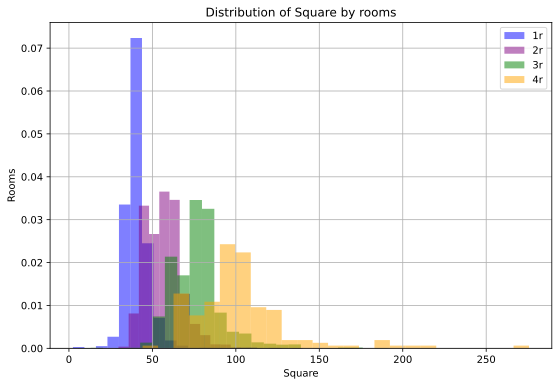

(44.0, 63.0, 83.0, 111.0)

In [193]:
rooms = df_train['Rooms']
plt.figure(figsize = (9, 6))

df_train.loc[rooms == 1, 'Square'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='1r')
df_train.loc[rooms == 2, 'Square'].hist(bins=25, density=True, color ='Purple', alpha=0.5, label ='2r')
df_train.loc[rooms == 3, 'Square'].hist(bins=25, density=True, color ='g', alpha=0.5, label ='3r')
df_train.loc[rooms == 4, 'Square'].hist(bins=25, density=True, color ='Orange', alpha=0.5, label ='4r')
plt.xlabel('Square')
plt.ylabel('Rooms')
plt.title('Distribution of Square by rooms')
plt.legend()
plt.show()

quantile1 = np.around(df_train.loc[rooms == 1, 'Square'].quantile(.75))
quantile2 = np.around(df_train.loc[rooms == 2, 'Square'].quantile(.75))
quantile3 = np.around(df_train.loc[rooms == 3, 'Square'].quantile(.75))
quantile4 = np.around(df_train.loc[rooms == 4, 'Square'].quantile(.75))

quantile1, quantile2, quantile3, quantile4

Заменим количество комнат в выбросах на количество комнат, характерное для данной площади:

In [186]:
outrooms_train = df_train.loc[df_train['Rooms'].between(5, 19) | (df_train['Rooms'] == 0)]

for i in outrooms_train.index:
    if (outrooms_train.loc[(i),'Square']) < quantile1:
        (outrooms_train.loc[(i),'Rooms']) = 1
    elif (outrooms_train.loc[(i),'Square']) < quantile2:
        (outrooms_train.loc[(i),'Rooms']) = 2
    elif (outrooms_train.loc[(i),'Square']) < quantile3:
        (outrooms_train.loc[(i),'Rooms']) = 3
    elif (outrooms_train.loc[(i),'Square']) > quantile3:
        (outrooms_train.loc[(i),'Rooms']) = 4
df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] > 4), 'Rooms'] = outrooms_train['Rooms']

df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] > 4)]

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, Shops_2, Price, OutliersSquare, OutliersLifeSquare, MismatchedSquares, OutliersKitchen, OutliersRooms]
Index: []

Также заменим в test

In [194]:
outrooms_test = df_test.loc[df_test['Rooms'].between(5, 19) | (df_test['Rooms'] == 0)]

for i in outrooms_test.index:
    if (outrooms_test.loc[(i),'Square']) < quantile1:
        (outrooms_test.loc[(i),'Rooms']) = 1
    elif (outrooms_test.loc[(i),'Square']) < quantile2:
        (outrooms_test.loc[(i),'Rooms']) = 2
    elif (outrooms_test.loc[(i),'Square']) < quantile3:
        (outrooms_test.loc[(i),'Rooms']) = 3
    elif (outrooms_test.loc[(i),'Square']) > quantile3:
        (outrooms_test.loc[(i),'Rooms']) = 4
df_test.loc[(df_test['Rooms'] == 0) | (df_test['Rooms'] > 4), 'Rooms'] = outrooms_test['Rooms']

df_test.loc[(df_test['Rooms'] == 0) | (df_test['Rooms'] > 4)]

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, Shops_2, OutliersSquare, OutliersLifeSquare, MismatchedSquares, OutliersKitchen, OutliersRooms, NanLifeSquare]
Index: []

In [ ]:
# * `KitchenSquare`  

# Посчитаем долю площади кухни от общей площади кваритры, посмотрим на разброс значений
# df_train['KitchenPerc'] =  df_train['KitchenSquare'] / df_train['Square']
# df_test['KitchenPerc'] =  df_test['KitchenSquare'] / df_test['Square']

In [ ]:
# plt.figure(figsize = (9, 6))
# plt.plot(df_train['KitchenPerc'])
# plt.ylabel('Part of KitchenSquare')
# plt.show()

Видно, что в целом площадь кухни в среднем имеет одинаковую долю от всей площади, найдем эту долю и заменим площадь кухни в выбросах на значение, равное площади, умноженной на этот коэффициент. Также добавим биннарный флаг о том, что это выброс

In [ ]:
# median_kitchen_part = np.around(df_train['KitchenPerc'].median(), 3)
# median_kitchen_part

In [ ]:
# df_train.reset_index(inplace=True)
# df_train['OutliersKitchen'] = 0
# df_train.loc[(df_train['Square'] < df_train['KitchenSquare']) | 
#              (df_train['KitchenSquare'] > 50) | (df_train['KitchenSquare'] < 3) & 
#              ~(df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'] <= 5), 
#              'OutliersKitchen'] = 1

# df_test.reset_index(inplace=True)
# df_test['OutliersKitchen'] = 0
# df_test.loc[(df_test['Square'] < df_test['KitchenSquare']) |
#             (df_test['KitchenSquare'] > 50) | (df_test['KitchenSquare'] < 3) & 
#             ~(df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'] <= 5), 
#             'OutliersKitchen'] = 1

In [ ]:
# outkitchen_train = df_train.loc[df_train.OutliersKitchen == 1]
# outkitchen_train['KitchenSquare'] = np.around(outkitchen_train['Square'] * median_kitchen_part, 1)
# outkitchen_train['KitchenSquare']
# df_train['KitchenSquare'].loc[df_train.OutliersKitchen == 1] = outkitchen_train['KitchenSquare']

# outkitchen_test = df_test.loc[df_test.OutliersKitchen == 1]
# outkitchen_test['KitchenSquare'] = np.around(outkitchen_test['Square'] * median_kitchen_part, 1)
# outkitchen_test['KitchenSquare']
# df_test['KitchenSquare'].loc[df_test.OutliersKitchen == 1] = outkitchen_test['KitchenSquare']

* `LifeSquare`

В колонке жилой площади у нас есть очень много пропусков. Построим алгоритм, который предскажет нам эти значения, затем заполним ими пропуски. Предварительно добавим флаги о пустых значениях. Для обучения алгоритма заполнения пропусков будем использовать только train данные

In [196]:
df_train['NanLifeSquare'] = 0
df_train['NanLifeSquare'].loc[df_train['LifeSquare'].isnull()] = 1

df_test['NanLifeSquare'] = 0
df_test['NanLifeSquare'].loc[df_test['LifeSquare'].isnull()] = 1

In [197]:
print("train: ", df_train['NanLifeSquare'].value_counts(),
     "\ntest: ", df_test['NanLifeSquare'].value_counts(), sep='\n')

train: 
0    7885
1    2112
Name: NanLifeSquare, dtype: int64

test: 
0    3959
1    1041
Name: NanLifeSquare, dtype: int64


Построим модель после генерации новых признаков

* `HouseFloor` 

Проверим, нет ли у нас выбросов - домов, с нулевым числом этажей

In [198]:
df_train.loc[df_train['HouseFloor'] == 0]

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, Shops_2, Price, OutliersSquare, OutliersLifeSquare, MismatchedSquares, OutliersKitchen, OutliersRooms, NanLifeSquare]
Index: []

заполним нули так, чтобы считалось самое часто встречающееся значение высоты домов больших, чем этаж квартиры

In [199]:
floor = df_train['Floor'].loc[df_train['HouseFloor'] == 0]
house_floor = df_train['HouseFloor'].loc[df_train['HouseFloor'] == 0]

mode1=[]
for e in floor.values:
    a = df_train['HouseFloor'].loc[df_train['HouseFloor'].values >= e].mode()[0]
    mode1.append(a)
for i in range(0, len(mode1)):
    house_floor.values[i] = mode1[i]
df_train['HouseFloor'].loc[df_train['HouseFloor'] == 0] = house_floor
    
# аналогично заполняем для теста
floor2 = df_test['Floor'].loc[df_test['HouseFloor'] == 0]
house_floor2 = df_test['HouseFloor'].loc[df_test['HouseFloor'] == 0]

mode2=[]
for et in floor2.values:
    a = df_train['HouseFloor'].loc[df_train['HouseFloor'].values >= et].mode()[0]
    mode2.append(a)
for i in range(0, len(mode2)):
    house_floor2.values[i] = mode2[i]
df_test['HouseFloor'].loc[df_test['HouseFloor'] == 0] = house_floor2

df_test.loc[df_test['HouseFloor'] == 0]

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, Shops_2, OutliersSquare, OutliersLifeSquare, MismatchedSquares, OutliersKitchen, OutliersRooms, NanLifeSquare]
Index: []

* `Floor`  

Проверим, нет ли ситуации, когда этаж квартиры выше высоты дома

In [200]:
df_train.loc[df_train['Floor'] > df_train['HouseFloor']]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
14    10953          27    1.0   53.769097   52.408027            1.0      5   
16     2119          27    2.0   49.360648   31.993964            5.0      6   
21    11935          27    2.0   64.711835         NaN            1.0     15   
35     6486         200    3.0   85.280389   58.447967            9.0      6   
51    10103          94    1.0   35.280894   23.354176            6.0     11   
...     ...         ...    ...         ...         ...            ...    ...   
9984   2237          52    3.0   64.074977   47.633428            6.0     11   
9985  16159          27    1.0   38.968338         NaN            1.0     10   
9989   4145          96    3.0   90.055233   47.860231           11.0     26   
9991  11553           3    3.0  101.622794   51.628780           12.0     18   
9995     77          32    2.0   50.401785   30.476203            5.0      6   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
14           4.0       1977   0.072158         B         B         2   
16           5.0       1983   0.051815         B         B         5   
21           1.0       1977   0.211401         B         B         9   
35           5.0       1960   0.000000         B         B        33   
51           9.0       1971   0.282798         B         B        33   
...          ...        ...        ...       ...       ...       ...   
9984         9.0       1983   0.371149         B         B        34   
9985         1.0       1977   0.211401         B         B         9   
9989        24.0       2005   0.041116         B         B        53   
9991        17.0       2000   0.265089         B         B        37   
9995         5.0       1968   0.135650         B         B        46   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
14         629         1           NaN            0        0       A   
16        1227         0           NaN            0        0       B   
21        1892         0           NaN            0        1       B   
35        7425         1           NaN            2        5       B   
51        8667         2           NaN            0        6       B   
...        ...       ...           ...          ...      ...     ...   
9984      7065         1         750.0            2        5       B   
9985      1892         0           NaN            0        1       B   
9989     14892         4           NaN            1        4       B   
9991      5288         0        1937.0            3        2       B   
9995      7960         6         350.0            3       11       B   

              Price  OutliersSquare  OutliersLifeSquare  MismatchedSquares  \
14    140647.565937               0                   0                  0   
16    117000.381287               0                   0                  0   
21    127200.026511               0                   0                  0   
35    402871.916317               0                   0                  0   
51    148862.210174               0                   0                  0   
...             ...             ...                 ...                ...   
9984  226434.880156               0                   0                  0   
9985   95529.569405               0                   0                  0   
9989  441108.911237               0                   0                  0   
9991  212883.501504               0                   0                  0   
9995  196684.316040               0                   0                  0   

      OutliersKitchen  OutliersRooms  NanLifeSquare  
14                  0              0              0  
16                  0              0              0  
21                  0              0              1  
35                  0              0              0  
51                  0              0              0  
...               ...            ...            ...  
998

Предположим, что значения были перепутаны, поменяем их местами

In [201]:
floor_err = df_train['Floor'] > df_train['HouseFloor']
df_train['Floor'].loc[floor_err], df_train['HouseFloor'].loc[floor_err] = \
df_train['HouseFloor'].loc[floor_err], df_train['Floor'].loc[floor_err]

# для теста:
floor_err2 = df_test['Floor'] > df_test['HouseFloor']
df_test['Floor'].loc[floor_err2], df_test['HouseFloor'].loc[floor_err2] = \
df_test['HouseFloor'].loc[floor_err2], df_test['Floor'].loc[floor_err2]

In [202]:
# df_train.loc[df_train['Floor'] > df_train['HouseFloor']]
df_test.loc[df_test['Floor'] > df_test['HouseFloor']]

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, Shops_2, OutliersSquare, OutliersLifeSquare, MismatchedSquares, OutliersKitchen, OutliersRooms, NanLifeSquare]
Index: []

* `HouseYear`

есть дома, которые очень старые и одно странное значение, скорее всего ошибка.  
Заменим оба года

In [203]:
df_train.loc[(df_train['HouseYear'] > 2020) | (df_train['HouseYear'] < 1900)] 
# df_test.loc[(df_test['HouseYear'] > 2020) | (df_test['HouseYear'] < 1900)] 

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1497  10814         109    1.0  37.265070   20.239714            9.0    9.0   
4189  11607         147    2.0  44.791836   28.360393            5.0    4.0   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1497        12.0   20052011   0.136330         B         B        30   
4189         9.0       4968   0.319809         B         B        25   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1497      6141        10         262.0            3        6       B   
4189      4756        16        2857.0            5        8       B   

              Price  OutliersSquare  OutliersLifeSquare  MismatchedSquares  \
1497  254084.534396               0                   0                  0   
4189  243028.603096               0                   0                  0   

      OutliersKitchen  OutliersRooms  NanLifeSquare  
1497                0              0              0  
4189                0              0              0

In [204]:
df_train['HouseYear'][df_train['HouseYear'] == 4968] = 1968
df_train['HouseYear'][df_train['HouseYear'] == 20052011] = 2011

* `Healthcare_1` -????????????

В данном столбце очень много пропусков, его значение не очень ясно и не наблюдается связь с другими признаками, по-этому мы его удалим

In [206]:
df_train = df_train.drop(['Healthcare_1'], axis=1)
df_test = df_test.drop(['Healthcare_1'], axis=1)

In [207]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  9997 non-null   object 
 1   DistrictId          9997 non-null   int64  
 2   Rooms               9997 non-null   float64
 3   Square              9997 non-null   float64
 4   LifeSquare          7885 non-null   float64
 5   KitchenSquare       9997 non-null   float64
 6   Floor               9997 non-null   float64
 7   HouseFloor          9997 non-null   float64
 8   HouseYear           9997 non-null   int64  
 9   Ecology_1           9997 non-null   float64
 10  Ecology_2           9997 non-null   object 
 11  Ecology_3           9997 non-null   object 
 12  Social_1            9997 non-null   int64  
 13  Social_2            9997 non-null   int64  
 14  Social_3            9997 non-null   int64  
 15  Helthcare_2         9997 non-null   int64  
 16  Shops_

In [208]:
list(df_train.columns.values) 

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'OutliersSquare',
 'OutliersLifeSquare',
 'MismatchedSquares',
 'OutliersKitchen',
 'OutliersRooms',
 'NanLifeSquare']

Построим матрицу кореляций, чтобы предварительно оценить возможность создания новых признаков 

In [209]:
features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
            'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 
            'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'OutliersSquare',
            'OutliersLifeSquare', 'MismatchedSquares', 'OutliersKitchen', 'OutliersRooms',
            'NanLifeSquare']

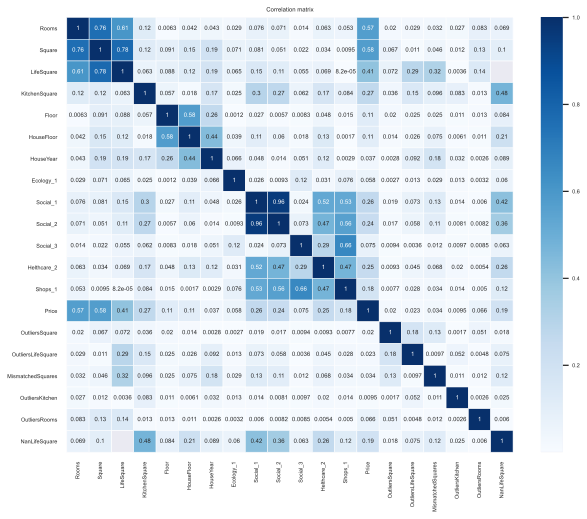

In [210]:
df_train[features].corr()
plt.figure(figsize=(10,8))

sns.set(font_scale=0.5)
sns.heatmap(df_train[features].corr().abs(), annot=True, linewidth=.5, cmap='Blues')
plt.title('Correlation matrix')
plt.show()

* Жилая и общая площади напрямую связаны с ценой
* Количество комнат также связаны с ценой, и зависит от площади
* Год постройки связан с этажностью дома и площадью (Возможно, чем старше, чем выше и больше площадь)
* Healthcare_2 сязан с Social_1 и Social_2, и все эти показатели связаны с Shops_1 - скорее всего, это спальные районы, в которых есть поликлиники и магазины


### Обработка категориальных признаков

* `Ecology_2` 
* `Ecology_3`
* `Shops_2`

In [211]:
df = pd.concat([df_train, df_test], axis=0)

In [212]:
cat_colnames = df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [213]:
for cat_colname in cat_colnames[1:]:
    print(str(cat_colname) + '\n\n' + \
          str(df[cat_colname].value_counts()) + \
          '\n' + '*' * 100 + '\n')

Ecology_2

B    14852
A      145
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    14573
A      424
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    13760
A     1237
Name: Shops_2, dtype: int64
****************************************************************************************************



добавим новый признак, который преобразуем в биннарный (One Hot Encoding)

In [214]:
df['Ecology_Concat23'] = df['Ecology_2'] + df['Ecology_3']

In [215]:
df = pd.concat([df, pd.get_dummies(df['Ecology_Concat23'])], axis=1)
df = df.drop('Ecology_Concat23', axis=1)

заменим Колонки с A и B на 0 и 1

In [216]:
for cat_colname in cat_colnames[1:]:
    df[cat_colname][df[cat_colname].values == 'A'] = 0
    df[cat_colname][df[cat_colname].values == 'B'] = 1
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')
    
df['Ecology_2'] = df['Ecology_2'].astype('int64')
df['Ecology_3'] = df['Ecology_3'].astype('int64')
df['Shops_2'] = df['Shops_2'].astype('int64')   

Ecology_2

1    14852
0      145
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

1    14573
0      424
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

1    13760
0     1237
Name: Shops_2, dtype: int64
****************************************************************************************************



In [217]:
df_train = df.loc[~df['Price'].isnull()]
df_test = df.loc[df['Price'].isnull()]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   object 
 1   DistrictId          5000 non-null   int64  
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          3959 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   float64
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   int64  
 11  Ecology_3           5000 non-null   int64  
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Helthcare_2         5000 non-null   int64  
 16  Shops_

### Построение новых признаков

* `PriceBySquare` цена за квадратный метр

In [218]:
# пока не буду добавлять признак, для него нужна отдельная модель
# df_train['PriceBySquare'] = df_train['Price'] / df_train['Square']

* `MeanSquareByRooms` средняя площадь квартир по комнатам

In [219]:
gp = df_train.groupby(['Rooms'])['Square'].mean()
df_train["MeanSquareByRooms"] = df_train['Rooms'].map(gp.to_dict())
df_test["MeanSquareByRooms"] = df_test['Rooms'].map(gp.to_dict())
gp

Rooms
1.0     41.353064
2.0     56.577969
3.0     77.009464
4.0    102.558169
Name: Square, dtype: float64

* `DeviaSquareByRooms` отклонение от средней площади

In [220]:
df_train['DeviaSquareByRooms'] = df_train['Square'] - df_train['MeanSquareByRooms']
df_test['DeviaSquareByRooms'] = df_test['Square'] - df_test['MeanSquareByRooms']

* `RatioSquareToMean` - отношение площади к средней площади по комнатам

In [221]:
df_train['RatioSquareToMean'] = df_train['Square'] / df_train['MeanSquareByRooms'] - 1
df_test['RatioSquareToMean'] = df_test['Square'] / df_test['MeanSquareByRooms'] - 1

* `DistrictSize` - размер района по количеству наблюдений

In [222]:
DistrictSize = df_train['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
df_train = df_train.merge(DistrictSize, on='DistrictId', how='left')
df_test = df_test.merge(DistrictSize, on='DistrictId', how='left')
df_test['DistrictSize'].fillna(0, inplace=True)

* `MedPriceByDistrict` - средняя цена по площади

In [223]:
MedPriceByDistrict = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})
df_train = df_train.merge(MedPriceByDistrict, on=['DistrictId', 'Rooms'], how='left')
median = df_train['MedPriceByDistrict'].median()
df_test = df_test.merge(MedPriceByDistrict, on=['DistrictId', 'Rooms'], how='left')
df_test['MedPriceByDistrict'].fillna(median, inplace=True)

* `MedPricePerM2ByDistrict` - средняя цена за 1 м2 по району

In [224]:
df_train['MedPricePerM2ByDistrict'] = df_train['MedPriceByDistrict'] / df_train['Square']
df_test['MedPricePerM2ByDistrict'] = df_test['MedPriceByDistrict'] / df_test['Square']

* `MedPriceByRooms` - средняя цена по комнатам (возможно, лучше удалить)

In [225]:
# возможно, лучше удалить
MedPriceByRooms = df_train.groupby(['Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByRooms'})
df_train = df_train.merge(MedPriceByRooms, on=['Rooms'], how='left')
df_test = df_test.merge(MedPriceByRooms, on=['Rooms'], how='left')

* `MedSquareByRoomsDist` - средняя площадь по комнатам

In [226]:
MedSquareByRoomsDist = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Square':'median'})\
                       .rename(columns={'Square':'MedSquareByRoomsDist'})
df_train = df_train.merge(MedSquareByRoomsDist, on=['DistrictId', 'Rooms'], how='left')
median = df_train['MedSquareByRoomsDist'].median()
df_test = df_test.merge(MedSquareByRoomsDist, on=['DistrictId', 'Rooms'], how='left')
df_test['MedSquareByRoomsDist'].fillna(median, inplace=True)

* `MedPriceByRoomsDist` - средняя цена по району за квартиру по количеству комнат 

In [227]:
MedPriceByRoomsDist = df_train.groupby(['DistrictId', 'MedSquareByRoomsDist'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByRoomsDist'})
df_train = df_train.merge(MedPriceByRoomsDist, on=['DistrictId', 'MedSquareByRoomsDist'], how='left')
median = df_train['MedPriceByRoomsDist'].median()
df_test = df_test.merge(MedPriceByRoomsDist, on=['DistrictId', 'MedSquareByRoomsDist'], how='left')
df_test['MedPriceByRoomsDist'].fillna(median, inplace=True)

* `HealthcareToSocialToSocial` - социальные показатели в каждой из категорий здравоохранения

In [228]:
HealthcareToSocial = df_train.groupby(['Helthcare_2'], as_index=False)\
                    .agg({'Social_1':lambda x:x.value_counts().index[0]})\
                    .rename(columns={'Social_1':'HealthcareToSocial'})
df_train = df_train.merge(HealthcareToSocial, on='Helthcare_2', how='left')
df_test = df_test.merge(HealthcareToSocial, on='Helthcare_2', how='left')

* `IsDistrictLarge` размер района

In [229]:
df_train['IsDistrictLarge'] = (df_train['DistrictSize'] > 100).astype(int)
df_test['IsDistrictLarge'] = (df_test['DistrictSize'] > 100).astype(int)

In [230]:
df_train.IsDistrictLarge.value_counts()

1    5067
0    4930
Name: IsDistrictLarge, dtype: int64

* `DistrictId` - id района, сделаем строкой

In [231]:
df_train['DistrictId'] = df_train['DistrictId'].astype(str)
df_test['DistrictId'] = df_test['DistrictId'].astype(str)

* `TotalAppartsByYear` - суммарное количество квартир по году постройки дома

In [232]:
TotalAppartsByYear = df_train['HouseYear'].value_counts().reset_index()\
                    .rename(columns={'index':'HouseYear', 'HouseYear':'TotalAppartsByYear'})
df_train = df_train.merge(TotalAppartsByYear, on='HouseYear', how='left')
df_test = df_test.merge(TotalAppartsByYear, on='HouseYear', how='left')
df_test['TotalAppartsByYear'].fillna(0, inplace=True)

* `IsHouseOld` - категодия дома в зависимости от его возраста (1 - старый дом, 0 - современный)

In [233]:
df_train['IsHouseOld'] = (df_train['HouseYear'] < 1970).astype(int)
df_test['IsHouseOld'] = (df_test['HouseYear'] < 1970).astype(int)

* `IsHouseYearPopular` - популярен ли год постройки

In [234]:
df_train['IsHouseYearPopular'] = (df_train['TotalAppartsByYear'] > 100).astype(int)
df_test['IsHouseYearPopular'] = (df_test['TotalAppartsByYear'] > 100).astype(int)

In [235]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       5000 non-null   object 
 1   DistrictId               5000 non-null   object 
 2   Rooms                    5000 non-null   float64
 3   Square                   5000 non-null   float64
 4   LifeSquare               3959 non-null   float64
 5   KitchenSquare            5000 non-null   float64
 6   Floor                    5000 non-null   float64
 7   HouseFloor               5000 non-null   float64
 8   HouseYear                5000 non-null   int64  
 9   Ecology_1                5000 non-null   float64
 10  Ecology_2                5000 non-null   int64  
 11  Ecology_3                5000 non-null   int64  
 12  Social_1                 5000 non-null   int64  
 13  Social_2                 5000 non-null   int64  
 14  Social_3                

Удалим малонаселенные районы

In [236]:
# df_test.info()
# df_train = df_train.loc[df_train['DistrictSize'] > 50]

In [237]:
df_train.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'OutliersSquare',
 'OutliersLifeSquare',
 'MismatchedSquares',
 'OutliersKitchen',
 'OutliersRooms',
 'NanLifeSquare',
 'AB',
 'BA',
 'BB',
 'MeanSquareByRooms',
 'DeviaSquareByRooms',
 'RatioSquareToMean',
 'DistrictSize',
 'MedPriceByDistrict',
 'MedPricePerM2ByDistrict',
 'MedPriceByRooms',
 'MedSquareByRoomsDist',
 'MedPriceByRoomsDist',
 'HealthcareToSocial',
 'IsDistrictLarge',
 'TotalAppartsByYear',
 'IsHouseOld',
 'IsHouseYearPopular']

### Заполним нули LifeSquare моделью

In [238]:
columns = df_train.columns.to_list()[2:]
columns.remove('LifeSquare')
columns.remove('Price')
columns

['Rooms',
 'Square',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'OutliersSquare',
 'OutliersLifeSquare',
 'MismatchedSquares',
 'OutliersKitchen',
 'OutliersRooms',
 'NanLifeSquare',
 'AB',
 'BA',
 'BB',
 'MeanSquareByRooms',
 'DeviaSquareByRooms',
 'RatioSquareToMean',
 'DistrictSize',
 'MedPriceByDistrict',
 'MedPricePerM2ByDistrict',
 'MedPriceByRooms',
 'MedSquareByRoomsDist',
 'MedPriceByRoomsDist',
 'HealthcareToSocial',
 'IsDistrictLarge',
 'TotalAppartsByYear',
 'IsHouseOld',
 'IsHouseYearPopular']

In [239]:
features_LS = columns
target_LS = 'LifeSquare'

X_train_LS = df_train[features_LS].loc[df_train[target_LS].notnull()]
Y_train_LS = df_train[target_LS].loc[df_train[target_LS].notnull()]
X_test_LS = df_train[features_LS].loc[df_train[target_LS].isnull()]
X_test_LS2 = df_test[features_LS].loc[df_test[target_LS].isnull()]

# X_train, X_test, y_train, y_test = train_test_split(X_train_LS, Y_train_LS, shuffle=True, test_size=0.3, random_state=21)

In [240]:
rf_for_LS = RandomForestRegressor(max_depth=7, max_features=11, n_estimators=300, random_state=42)
# rf_for_LS.fit(X_train, y_train)

rf_for_LS.fit(X_train_LS, Y_train_LS)

# Y_test_LS = lr_for_LS.predict(X_test_LS)
# Y_train_preds = rf_for_LS.predict(X_train)
# Y_test_preds = rf_for_LS.predict(X_test)

# evaluate_preds(y_train, Y_train_preds, y_test, Y_test_preds)

RandomForestRegressor(max_depth=7, max_features=11, n_estimators=300,
                      random_state=42)

In [241]:
df_train.loc[df_train['LifeSquare'].isnull(), 'LifeSquare'] = rf_for_LS.predict(X_test_LS)
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = rf_for_LS.predict(X_test_LS2) 

In [242]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       5000 non-null   object 
 1   DistrictId               5000 non-null   object 
 2   Rooms                    5000 non-null   float64
 3   Square                   5000 non-null   float64
 4   LifeSquare               5000 non-null   float64
 5   KitchenSquare            5000 non-null   float64
 6   Floor                    5000 non-null   float64
 7   HouseFloor               5000 non-null   float64
 8   HouseYear                5000 non-null   int64  
 9   Ecology_1                5000 non-null   float64
 10  Ecology_2                5000 non-null   int64  
 11  Ecology_3                5000 non-null   int64  
 12  Social_1                 5000 non-null   int64  
 13  Social_2                 5000 non-null   int64  
 14  Social_3                

* `RatioLifeSquareToSquare` - доля жилой площади к общей

In [243]:
df_train['RatioLifeSquareToSquare'] = df_train['LifeSquare'] / df_train['Square']
df_test['RatioLifeSquareToSquare'] = df_test['LifeSquare'] / df_test['Square']

* `MeanLifeSquareByRooms` - доля жилой площади к общей

In [244]:
MeanLifeSquareByRooms = df_train.groupby(['Rooms'])['LifeSquare'].mean()
df_train["MeanLifeSquareByRooms"] = df_train['Rooms'].map(MeanLifeSquareByRooms.to_dict())
df_test["MeanLifeSquareByRooms"] = df_test['Rooms'].map(MeanLifeSquareByRooms.to_dict())
MeanLifeSquareByRooms

Rooms
1.0    27.121805
2.0    39.316988
3.0    53.880498
4.0    70.534307
Name: LifeSquare, dtype: float64

### Построение модели для предсказания цены за квадратный метр

Построим модель для предсказания цены за квадратный метр, чтобы можно было сравнить прогнозы, либо усреднить их

In [245]:
"""
features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 
            'HouseFloor', 'HouseYear', 'Ecology_1',  
            'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']
'''
new_features = [ 'KitchenPerc',  
                'NanLifeSquare', 'MeanSquareByRooms', 
                'DeviaSquareByRooms', 'RatioSquareToMean', 'DistrictSize', 
                'MedPriceByDistrict', 'MedSquareByRooms', 
                'MedPriceByRoomsDist', 'RatioHealthcareToSocial']
#'OutliersSquare', 'OutliersKitchen', 'OutliersRooms', 'bigger_then_mean'
'''
new_features = [ 'MeanSquareByRooms', 'DeviaSquareByRooms', 'RatioSquareToMean', 'DistrictSize', 'IsDistrictLarge',
                'MedPriceByDistrict', 'MedPriceByRooms']

target = 'PriceBySquare'

X = df_train[features + new_features]
Y_1 = df_train[target]

X_train, X_test, Y_1_train, Y_1_test = train_test_split(X, Y_1, test_size=0.3, random_state=21, shuffle=True)
"""

"\nfeatures = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', \n            'HouseFloor', 'HouseYear', 'Ecology_1',  \n            'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']\n'''\nnew_features = [ 'KitchenPerc',  \n                'NanLifeSquare', 'MeanSquareByRooms', \n                'DeviaSquareByRooms', 'RatioSquareToMean', 'DistrictSize', \n                'MedPriceByDistrict', 'MedSquareByRooms', \n                'MedPriceByRoomsDist', 'RatioHealthcareToSocial']\n#'OutliersSquare', 'OutliersKitchen', 'OutliersRooms', 'bigger_then_mean'\n'''\nnew_features = [ 'MeanSquareByRooms', 'DeviaSquareByRooms', 'RatioSquareToMean', 'DistrictSize', 'IsDistrictLarge',\n                'MedPriceByDistrict', 'MedPriceByRooms']\n\ntarget = 'PriceBySquare'\n\nX = df_train[features + new_features]\nY_1 = df_train[target]\n\nX_train, X_test, Y_1_train, Y_1_test = train_test_split(X, Y_1, test_size=0.3, random_state=21, shuffle=True)\n"

In [246]:
# rf_1 = RandomForestRegressor(max_depth=8, max_features=11, n_estimators=400, random_state=21)
 
# rf_1.fit(X_train, Y_1_train)
# Y_1_train_preds = rf_1.predict(X_train)
# Y_1_test_preds = rf_1.predict(X_test)

# evaluate_preds(Y_1_train, Y_1_train_preds, Y_1_test, Y_1_test_preds)

In [247]:
# params = {'max_depth' : [7,8, 9, 10, 11],
#           'max_features' : [6, 7, 8, 9, 10],
#           'n_estimators' : [150, 200, 250, 300]}

# GridSearch = GridSearchCV (rf_1, params, scoring='r2', 
#                           cv=KFold(n_splits = 5, random_state=21, shuffle=True))
# GridSearch.fit(X_train, Y_1_train)

In [248]:
# GridSearch.best_params_

In [249]:
# feature_importances = pd.DataFrame(zip(X_train.columns, rf_1.feature_importances_), 
#                                    columns=['feature_name', 'importance'])
# feature_importances.sort_values(by='importance', ascending=False)

### Перекрестная проверка для цены за квадратный метр

In [250]:
# cv_score = cross_val_score(
#     rf_1,
#     X.fillna(-9999),
#     Y_1,
#     scoring='r2',
#     cv=KFold(n_splits=5, shuffle=True, random_state=1)
# )
# cv_score

In [251]:
# cv_score.mean(), cv_score.std()

In [252]:
# cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

In [253]:
# df_test['PriceBySquare'] = rf_1.predict(df_test[features + new_features])

### Сохранение данных

In [254]:
df_train.to_csv(PREPARED_TRAIN_DATASET_PATH, index=False, encoding='utf-8')
df_test.to_csv(PREPARED_TEST_DATASET_PATH, index=False, encoding='utf-8')

### Построение модели для предсказания цены на недвижимость

In [255]:
df_train.columns.to_list()[2:]

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'OutliersSquare',
 'OutliersLifeSquare',
 'MismatchedSquares',
 'OutliersKitchen',
 'OutliersRooms',
 'NanLifeSquare',
 'AB',
 'BA',
 'BB',
 'MeanSquareByRooms',
 'DeviaSquareByRooms',
 'RatioSquareToMean',
 'DistrictSize',
 'MedPriceByDistrict',
 'MedPricePerM2ByDistrict',
 'MedPriceByRooms',
 'MedSquareByRoomsDist',
 'MedPriceByRoomsDist',
 'HealthcareToSocial',
 'IsDistrictLarge',
 'TotalAppartsByYear',
 'IsHouseOld',
 'IsHouseYearPopular',
 'RatioLifeSquareToSquare',
 'MeanLifeSquareByRooms']

In [256]:
features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 
            'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 
            'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']

# new_features = ['OutliersRooms', 'OutliersSquare', 'KitchenPerc', 'OutliersKitchen',
#                 'NanLifeSquare', 'AB', 'BA', 'BB', 'MeanSquareByRooms', 'DeviaSquareByRooms',
#                  'DistrictSize', 'MedPriceByDistrict',
#                 'MedPricePerM2ByDistrict', 'MedSquareByRoomsDist', 'MedPriceByRoomsDist',
#                 'HealthcareToSocial', 'IsDistrictLarge', 'TotalAppartsByYear',
#                 'IsHouseOld', 'IsHouseYearPopular', 'RatioLifeSquareToSquare',
#                  'MeanLifeSquareByRooms', 'MedPriceByRooms', 'RatioSquareToMean']
new_features = ['OutliersSquare', 'OutliersLifeSquare', 'MismatchedSquares', 'OutliersKitchen',
                'OutliersRooms', 'NanLifeSquare', 'AB', 'BA', 'BB', 'MeanSquareByRooms',
                'DeviaSquareByRooms', 'RatioSquareToMean', 'DistrictSize', 'MedPriceByDistrict',
                'MedPricePerM2ByDistrict', 'MedPriceByRooms', 'MedSquareByRoomsDist',
                'MedPriceByRoomsDist', 'HealthcareToSocial', 'IsDistrictLarge',
                'TotalAppartsByYear', 'IsHouseOld', 'IsHouseYearPopular',
                'RatioLifeSquareToSquare', 'MeanLifeSquareByRooms']
# 

target = 'Price'

X = df_train[features + new_features]
Y_2 = df_train[target]

X_train, X_test, Y_2_train, Y_2_test = train_test_split(X, Y_2, test_size=0.3, random_state=42, shuffle=True)

Train R2:	0.966
Test R2:	0.749


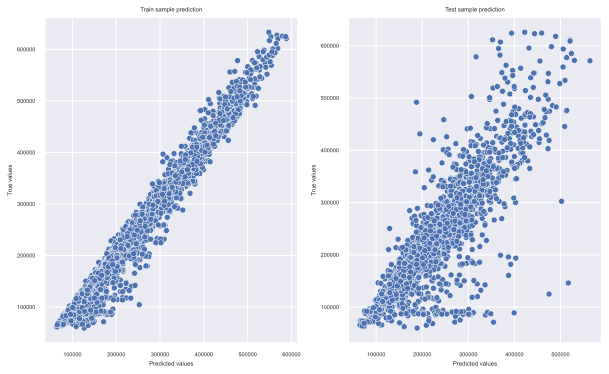

In [258]:
rf_2 = RandomForestRegressor(max_depth=20, max_features=5, n_estimators=1000, random_state=21)
#  
rf_2.fit(X_train, Y_2_train)
Y_2_train_preds = rf_2.predict(X_train)
Y_2_test_preds = rf_2.predict(X_test)

evaluate_preds(Y_2_train, Y_2_train_preds, Y_2_test, Y_2_test_preds)

In [259]:
cv_score = cross_val_score(
    rf_2,
    X.fillna(-9999),
    Y_2,
    scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=40)
)
cv_score

array([0.76957243, 0.7443041 , 0.75945207, 0.80842893, 0.74063579])

In [260]:
cv_score.mean(), cv_score.std()

(0.7644786628926561, 0.024324204020438518)

In [261]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.7401544588722175, 0.7888028669130946)

In [262]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_2.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

feature_name  importance
29       MedPriceByDistrict    0.144636
33      MedPriceByRoomsDist    0.143566
1                    Square    0.092741
32     MedSquareByRoomsDist    0.049025
28             DistrictSize    0.042208
26       DeviaSquareByRooms    0.038204
27        RatioSquareToMean    0.038024
31          MedPriceByRooms    0.036582
2                LifeSquare    0.035895
30  MedPricePerM2ByDistrict    0.033309
40    MeanLifeSquareByRooms    0.032336
25        MeanSquareByRooms    0.031437
11                 Social_2    0.029525
0                     Rooms    0.028765
10                 Social_1    0.025671
12                 Social_3    0.021085
36       TotalAppartsByYear    0.020989
3             KitchenSquare    0.019563
39  RatioLifeSquareToSquare    0.019257
6                 HouseYear    0.018132
5                HouseFloor    0.016791
4                     Floor    0.013433
7                 Ecology_1    0.013170
14                  Shops_1    0.011582
35          IsDistrictLarge    0.011081
13              Helthcare_2    0.009504
34       HealthcareToSocial    0.008681
38       IsHouseYearPopular    0.006928
37               IsHouseOld    0.001592
21            NanLifeSquare    0.001589
15                  Shops_2    0.001006
18        MismatchedSquares    0.000777
24                       BB    0.000582
9                 Ecology_3    0.000485
23                       BA    0.000465
16           OutliersSquare    0.000464
17       OutliersLifeSquare    0.000394
22                       AB    0.000192
8                 Ecology_2    0.000170
20            OutliersRooms    0.000102
19          OutliersKitchen    0.000058

### Теперь сделаем предсказания на test_df

In [263]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       5000 non-null   object 
 1   DistrictId               5000 non-null   object 
 2   Rooms                    5000 non-null   float64
 3   Square                   5000 non-null   float64
 4   LifeSquare               5000 non-null   float64
 5   KitchenSquare            5000 non-null   float64
 6   Floor                    5000 non-null   float64
 7   HouseFloor               5000 non-null   float64
 8   HouseYear                5000 non-null   int64  
 9   Ecology_1                5000 non-null   float64
 10  Ecology_2                5000 non-null   int64  
 11  Ecology_3                5000 non-null   int64  
 12  Social_1                 5000 non-null   int64  
 13  Social_2                 5000 non-null   int64  
 14  Social_3                

In [264]:

'''
features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 
            'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 
            'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']

new_features = ['AB', 'BA', 'BB', 'MeanSquareByRooms', 'DeviaSquareByRooms',
                'RatioSquareToMean', 'DistrictSize', 'IsDistrictLarge',
                'MedPriceByDistrict', 'MedPriceByRooms', 'MedPriceByRoomsDist',  
                'OutliersSquare', 'OutliersKitchen', 'OutliersRooms', 'KitchenPerc']
'''
X_train_f = df_train[features + new_features]
Y_train_f = df_train['Price']
X_test_f = df_test[features + new_features]

rf_2 = RandomForestRegressor(max_depth=20, max_features=5, n_estimators=1000, random_state=21)
# max_depth=19, max_features=5, n_estimators=400,
rf_2.fit(X_train_f, Y_train_f)

Y_test_f = rf_2.predict(X_test_f)
Id = df_test['Id'].values

In [265]:
# df_test['Price2'] =  df_test['PriceBySquare'] * df_test['Square']
# Price = (df_test['Price2'].values + Y_test_f)/2
# Price

In [266]:
Y_test = pd.DataFrame({'Id': Id, 'Price':Y_test_f}, columns=['Id','Price'])
Y_test.to_csv('Sokolova_predictions_10.csv', header=True, index=False, encoding='utf-8')

* Предсказательная модель для цены за квадратный метр
* Предсказательная модель для цены
* Добавить столбец Цена исходя из цены за квадрат
* Усреднение прогноза